In [123]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from torchvision import datasets, transforms

In [3]:
torch.manual_seed(42)
np.random.seed(42)

In [7]:
!nvidia-smi

Wed Dec 30 09:19:08 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [8]:
batch_size = 256
num_workers = 10
pin_memory = True

In [11]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
dataset1 = datasets.MNIST('../data', train=True, 
                          download=True, transform=transform)
dataset2 = datasets.MNIST('../data', train=False, 
                          transform=transform)

In [15]:
train_loader = torch.utils.data.DataLoader(dataset1, shuffle=True, batch_size=batch_size, pin_memory=True, num_workers=10)
test_loader = torch.utils.data.DataLoader(dataset2, batch_size=batch_size, pin_memory=True, num_workers=10)

In [104]:
class ModelInfo:

    def print_model_info(self):
        model_parameters = filter(lambda p: p.requires_grad, self.parameters())
        params = sum([np.prod(p.size()) for p in model_parameters])
        print("Number of model's trainable parameters: {}".format(params))

In [105]:
class MyVGGStyleModel(nn.Module, ModelInfo):
    def __init__(self, in_channels: int, num_classes: int):
        super(MyVGGStyleModel, self).__init__()

        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.MaxPool2d(2)
        )

        self.block2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.MaxPool2d(2)
        )

        self.block3 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.MaxPool2d(2)
        )

        self.block4 = nn.Sequential(
            nn.Conv2d(256, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.MaxPool2d(2)
        )

        self.flatten = nn.Flatten()

        self.fcn = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(True),
            nn.Dropout(p=0.5),
            nn.Linear(256, num_classes)
        )

        self.print_model_info()

    def forward(self, x):
        x = self.block1(x)

        # print(x.shape) torch.Size([B, 64, 14, 14])
        x = self.block2(x)

        # print(x.shape) torch.Size([B, 128, 7, 7])
        x = self.block3(x)

        # print(x.shape) torch.Size([B, 256, 3, 3])
        x = self.block4(x)

        # print(x.shape) torch.Size([B, 512, 1, 1])
        x = self.flatten(x)

        out = self.fcn(x)

        return out

In [112]:
class CBRModel(nn.Module, ModelInfo):
    def __init__(self, in_channels: int, num_classes: int):
        super(CBRModel, self).__init__()

        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels, 32, 3),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.Conv2d(32, 64, 3),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.MaxPool2d(2)
        )

        self.block2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.MaxPool2d(2)
        )

        self.flatten = nn.Flatten()

        self.fcn = nn.Sequential(
            nn.Linear(128 * 6 * 6, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 256),
            nn.ReLU(True),
            nn.Linear(256, num_classes)
        )

        self.print_model_info()

    def forward(self, x):
        x = self.block1(x)

        # print(x.shape) torch.Size([B, 64, 14, 14])
        x = self.block2(x)

        # print(x.shape)  torch.Size([B, 128, 6, 6])

        x = self.flatten(x)

        out = self.fcn(x)

        return out

In [113]:
class CBRModelSmall(CBNModel):

    def __init__(self, in_channels: int, num_classes: int):
        super(CBRModelSmall, self).__init__(in_channels, num_classes)

        self.fcn = nn.Sequential(
            nn.Linear(128 * 6 * 6, 256),
            nn.ReLU(True),
            nn.Linear(256, num_classes)
        )

        self.print_model_info()

In [114]:
def train_model(model, train_loader, optimizer, device, criterion):
    model.train()
    loss_values = list()

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)

        loss = criterion(output, target)
        loss.backward()

        loss_values.append(loss.detach().cpu().item())

        optimizer.step()

    return loss_values

In [115]:
def test_model(model, test_loader, device):
    model.eval()

    gts = list()
    preds = list()

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)
          
            y_hat = model(data)
            y_preds = y_hat.argmax(dim=1).detach().cpu()

            preds.extend(y_preds)
            gts.extend(target.detach().cpu())

    acc_score = accuracy_score(gts, preds)

    return acc_score

In [116]:
def fit_model(model, train_loader, test_loader, epochs):
    train_loss = list()
    acc_scores = list()

    criterion = nn.CrossEntropyLoss()
    device = torch.device("cuda")
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    model.to(device)
    best_weights = model.state_dict()

    for epoch in range(epochs):
        loss_values = train_model(
            model, train_loader, optimizer, device, criterion)
        train_loss.extend(loss_values)

        acc = test_model(model, test_loader, device)
        if len(acc_scores) != 0 and acc > max(acc_scores):
            best_weights = model.state_dict()
        acc_scores.append(acc)

        print(f'Epoch {epoch + 1}: Train mean CE Loss - {np.mean(loss_values)}, test acc - {acc}')

    plt.title('Train CE Loss')
    plt.plot(train_loss)
    plt.show()

    plt.title('Test Accuracies')
    plt.plot(acc_scores)
    plt.show()

    return best_weights

Number of model's trainable parameters: 5225546
Number of model's trainable parameters: 1423434
Epoch 1: Train mean CE Loss - 0.16601235045793844, test acc - 0.9894
Epoch 2: Train mean CE Loss - 0.03681954388368003, test acc - 0.9878
Epoch 3: Train mean CE Loss - 0.026683530679091495, test acc - 0.9926
Epoch 4: Train mean CE Loss - 0.021336244502937064, test acc - 0.9896
Epoch 5: Train mean CE Loss - 0.015586213278831874, test acc - 0.9925
Epoch 6: Train mean CE Loss - 0.015438471539094648, test acc - 0.9911
Epoch 7: Train mean CE Loss - 0.011788139458834888, test acc - 0.9897
Epoch 8: Train mean CE Loss - 0.010977140821744391, test acc - 0.9915
Epoch 9: Train mean CE Loss - 0.01079042380120843, test acc - 0.9923
Epoch 10: Train mean CE Loss - 0.010481913267149333, test acc - 0.9891


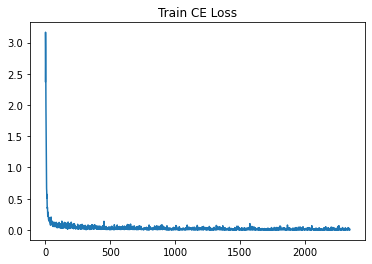

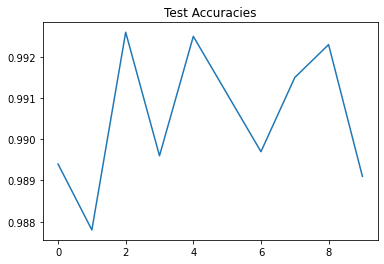

In [120]:
model = CBRModelSmall(1, 10)

cbr_model_small_state_dict = fit_model(model, train_loader, test_loader, 10)

Number of model's trainable parameters: 5225546
Epoch 1: Train mean CE Loss - 0.14629663548412475, test acc - 0.9884
Epoch 2: Train mean CE Loss - 0.038591666287802, test acc - 0.9908
Epoch 3: Train mean CE Loss - 0.027729518489634737, test acc - 0.9897
Epoch 4: Train mean CE Loss - 0.023873652218088032, test acc - 0.9847
Epoch 5: Train mean CE Loss - 0.018787970745866682, test acc - 0.9924
Epoch 6: Train mean CE Loss - 0.01583547582787937, test acc - 0.9927
Epoch 7: Train mean CE Loss - 0.013957476480727758, test acc - 0.9888
Epoch 8: Train mean CE Loss - 0.013924075901617317, test acc - 0.993
Epoch 9: Train mean CE Loss - 0.012706860574024254, test acc - 0.993
Epoch 10: Train mean CE Loss - 0.008709351092321857, test acc - 0.9917


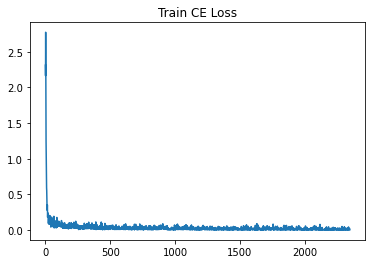

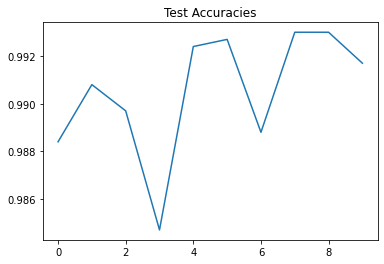

In [121]:
model = CBRModel(1, 10)

cbr_model_state_dict = fit_model(model, train_loader, test_loader, 10)

Number of model's trainable parameters: 7754570
Epoch 1: Train mean CE Loss - 0.18516006200633783, test acc - 0.9781
Epoch 2: Train mean CE Loss - 0.047917619668581386, test acc - 0.9825
Epoch 3: Train mean CE Loss - 0.035386890702028856, test acc - 0.9935
Epoch 4: Train mean CE Loss - 0.027463601621739726, test acc - 0.9924
Epoch 5: Train mean CE Loss - 0.024964849953539668, test acc - 0.9913
Epoch 6: Train mean CE Loss - 0.02223304490846126, test acc - 0.991
Epoch 7: Train mean CE Loss - 0.018369284253369304, test acc - 0.9932
Epoch 8: Train mean CE Loss - 0.016478419284574053, test acc - 0.9926
Epoch 9: Train mean CE Loss - 0.016399387599890458, test acc - 0.991
Epoch 10: Train mean CE Loss - 0.012374287581645903, test acc - 0.9936


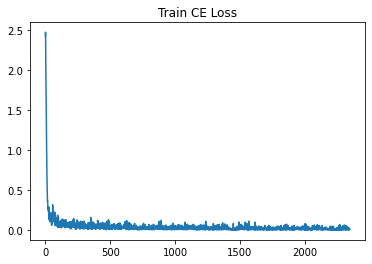

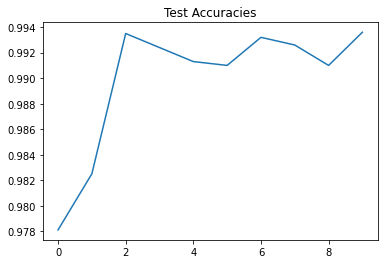

In [122]:
model = MyVGGStyleModel(1, 10)

vgg_model_state_dict = fit_model(model, train_loader, test_loader, 10)

 Лучше всего на тестовой выборке себя показала модель VGG-style с наибольшим количеством параметров (7М) из опробованных моделей, хотя отрыв от модели в 1.5M параметров всего лишь 0.1% точности.

In [182]:
def display_confusion_matrix(y_true, y_pred, cls_mapping):
    matrix = confusion_matrix(y_true, y_pred)
    display = ConfusionMatrixDisplay(matrix, cls_mapping)

    fig = plt.figure(figsize=(14, 9))
    accuracy = accuracy_score(y_true, y_pred)
    display.plot(ax=fig.add_subplot(111), values_format="d")

    plt.title("Accuracy: " + "{0:.5f}".format(accuracy))
    plt.show()

In [241]:
def display_image_matrix(test_dataset, y_true, y_pred, logits, cls_mapping):
    label_to_pred_image_index = np.zeros((len(cls_mapping), len(cls_mapping)), dtype=int)

    for i in range(len(cls_mapping)):
        for j in range(len(cls_mapping)):
            gt_indices = (gts == i)
            preds_indices = (preds == j)

            union_indices = np.logical_and(gt_indices, preds_indices)
            if union_indices.sum() > 0:
                masked_logits = logits[union_indices]
                
                max_val = np.amax(masked_logits)
                ind = np.where(logits == max_val)

                label_to_pred_image_index[i, j] = int(ind[0][0])

    classes = len(cls_mapping)

    for i in range(len(cls_mapping)):
        f, ax = plt.subplots(1, classes, figsize=(28, 28))
        for j in range(len(cls_mapping)):
            index = label_to_pred_image_index[i, j]
            if index == 0:
                ax[j].imshow(np.zeros(shape=(28, 28)), cmap='gray')
            else:
                sample = test_dataset[index][0]
                ax[j].imshow(sample.reshape(28, 28), cmap='gray')
                ax[j].set_title("True: {}\n Predict: {}".format(cls_mapping[i], cls_mapping[j]), fontsize=14)

In [242]:
def evaluate_model(model, test_loader, test_dataset, cls_mapping):
    model.eval()

    gts = list()
    preds = list()
    logits = list()

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)
          
            y_hat = model(data)
            y_preds = y_hat.argmax(dim=1).detach().cpu().numpy()
            y_logits = y_hat.amax(dim=1).detach().cpu().numpy()

            preds.extend(y_preds)
            logits.extend(y_logits)
            gts.extend(target.detach().cpu().numpy())

    gts = np.array(gts)
    preds = np.array(preds)
    logits = np.array(logits)
          
    display_confusion_matrix(gts, preds, cls_mapping)
    display_image_matrix(test_dataset, gts, preds, logits, cls_mapping)

Number of model's trainable parameters: 7754570


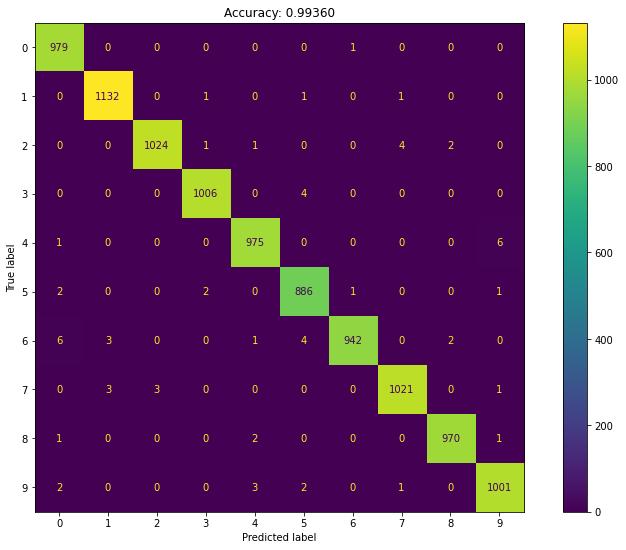

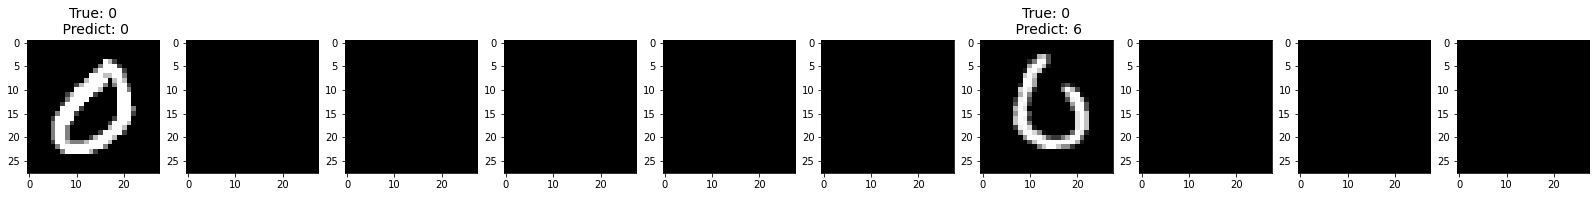

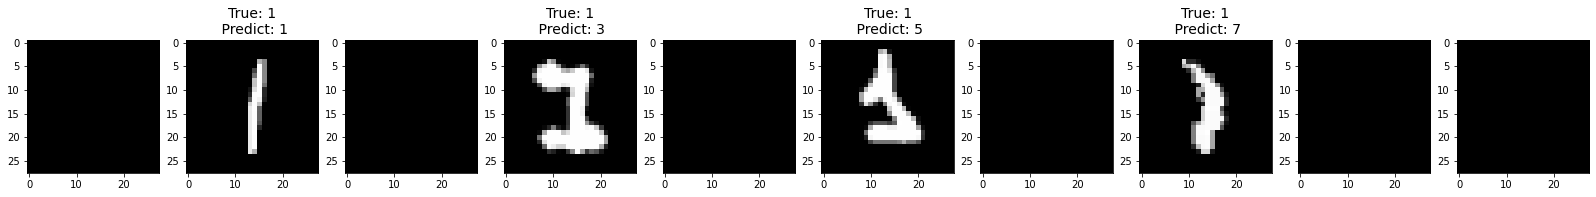

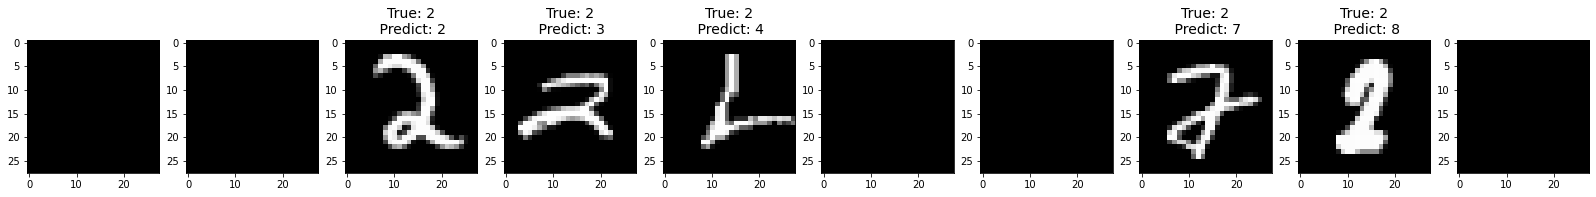

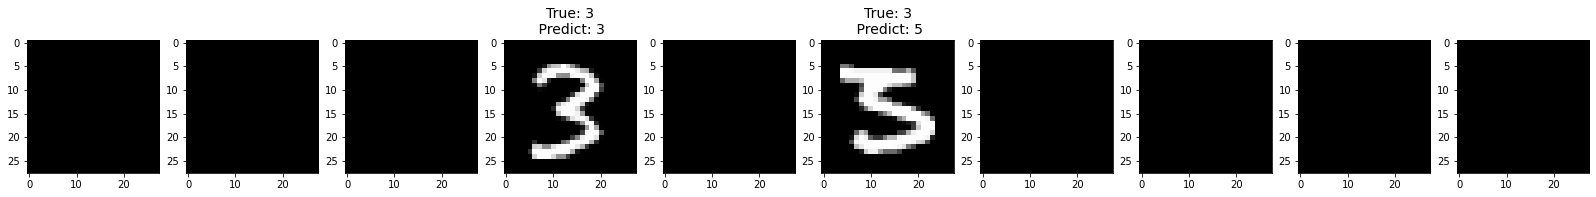

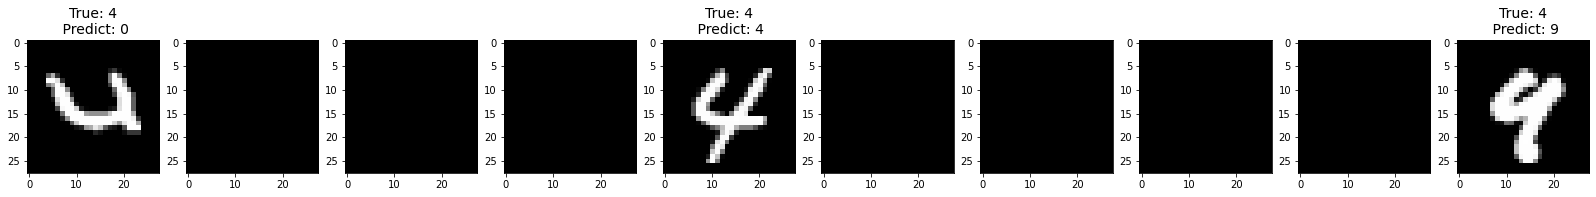

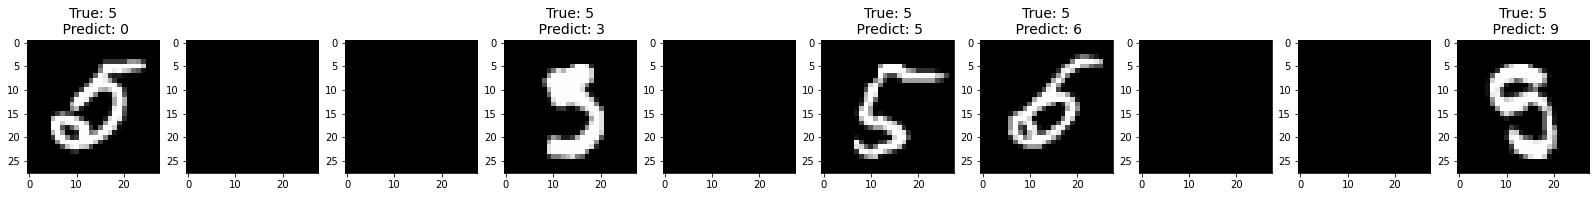

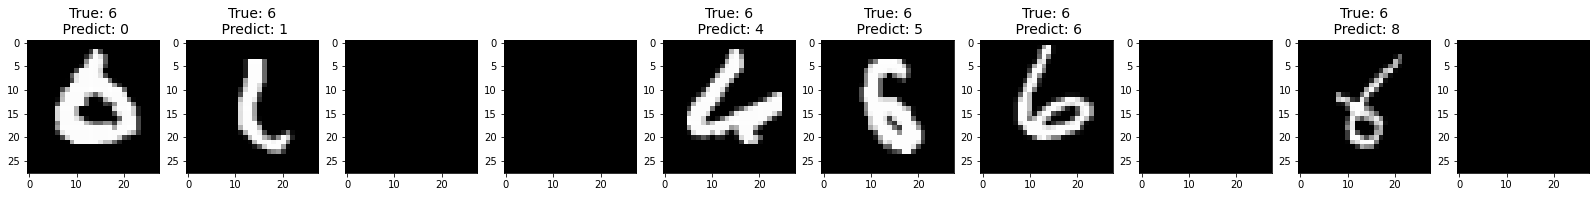

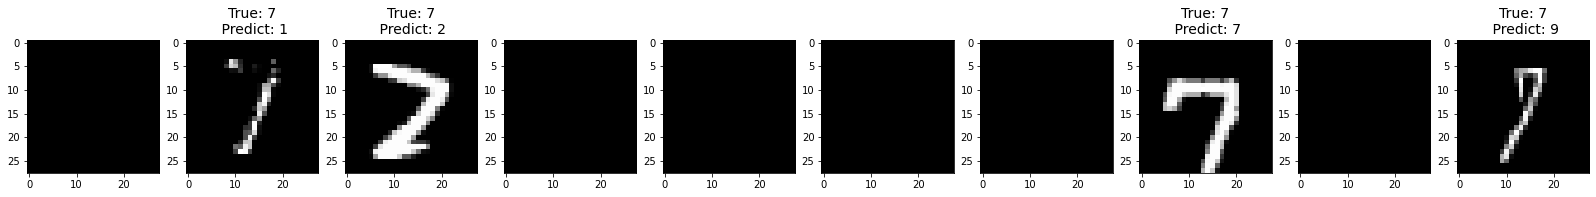

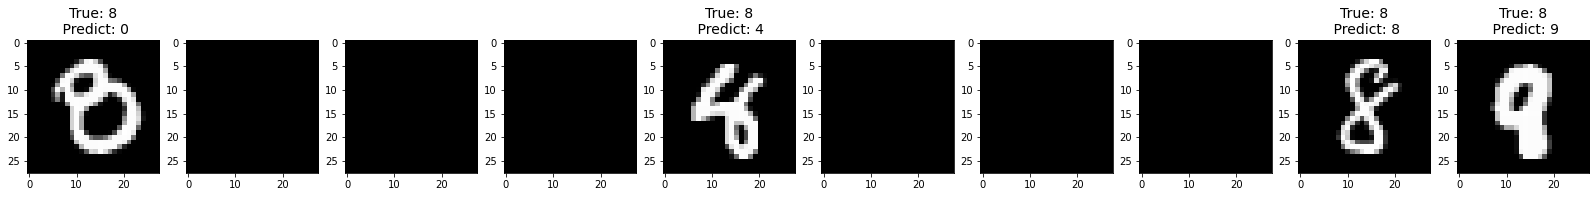

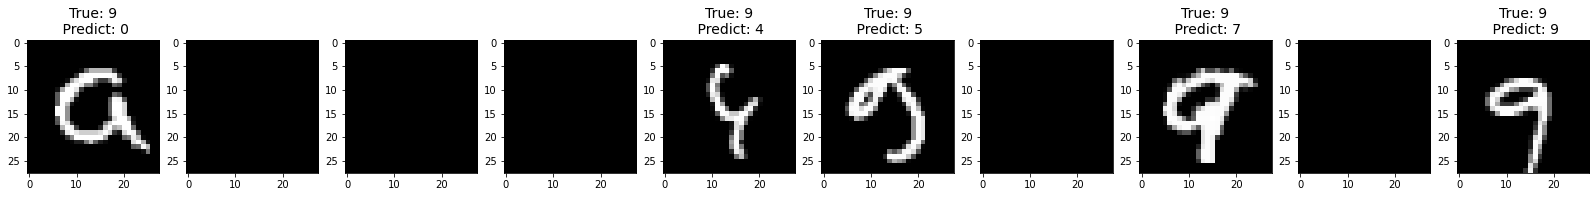

In [246]:
model = MyVGGStyleModel(1, 10)
model.load_state_dict(vgg_model_state_dict)
model.cuda()

evaluate_model(model, test_loader, dataset2, list(range(10)))

In [248]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_set = datasets.FashionMNIST("./data/fashion", download=True, 
                                  train=True, transform=transform)
test_set = datasets.FashionMNIST("./data/fashion", download=True, 
                                 train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(train_set, shuffle=True, batch_size=batch_size, pin_memory=True, num_workers=10)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, pin_memory=True, num_workers=10)

Extracting ./data/fashion/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/fashion/FashionMNIST/raw


Extracting ./data/fashion/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/fashion/FashionMNIST/raw


Extracting ./data/fashion/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/fashion/FashionMNIST/raw


Extracting ./data/fashion/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/fashion/FashionMNIST/raw
Processing...
Done!


Number of model's trainable parameters: 7754570
Epoch 1: Train mean CE Loss - 0.4760662485944464, test acc - 0.8827
Epoch 2: Train mean CE Loss - 0.27651060775239417, test acc - 0.9041
Epoch 3: Train mean CE Loss - 0.22663694984735328, test acc - 0.9097
Epoch 4: Train mean CE Loss - 0.19674499951144483, test acc - 0.9129
Epoch 5: Train mean CE Loss - 0.17221805643528065, test acc - 0.9095
Epoch 6: Train mean CE Loss - 0.1548747719919428, test acc - 0.9194
Epoch 7: Train mean CE Loss - 0.13620729799917403, test acc - 0.9241
Epoch 8: Train mean CE Loss - 0.12176063934222181, test acc - 0.9282
Epoch 9: Train mean CE Loss - 0.106340221775339, test acc - 0.932
Epoch 10: Train mean CE Loss - 0.08867077814771775, test acc - 0.9184
Epoch 11: Train mean CE Loss - 0.0834190031156895, test acc - 0.9194
Epoch 12: Train mean CE Loss - 0.0725671584539591, test acc - 0.9232
Epoch 13: Train mean CE Loss - 0.06372070427825477, test acc - 0.9241
Epoch 14: Train mean CE Loss - 0.05342006357188554, test a

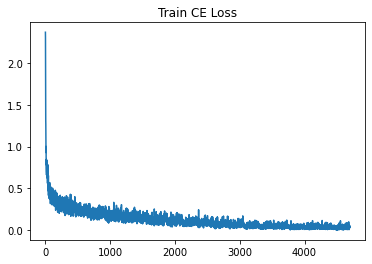

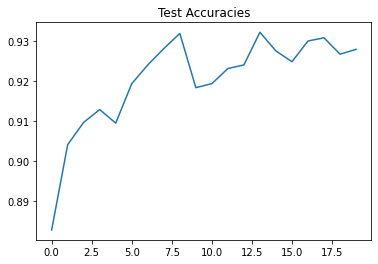

In [253]:
model = MyVGGStyleModel(1, 10)

vgg_model_state_dict = fit_model(model, train_loader, test_loader, 20)

Number of model's trainable parameters: 7754570


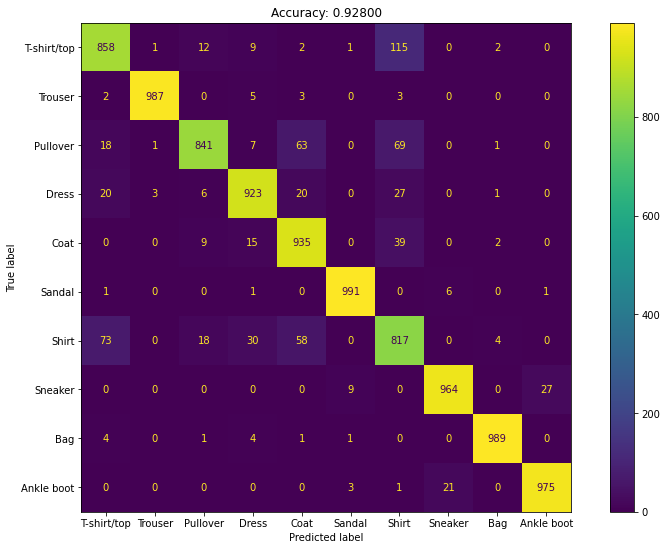

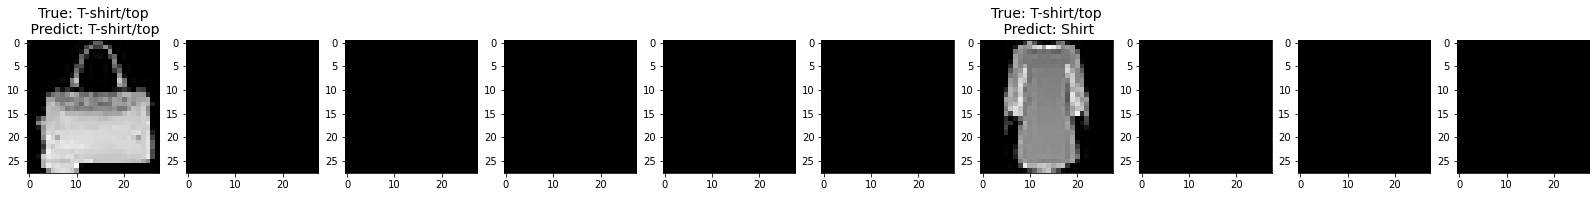

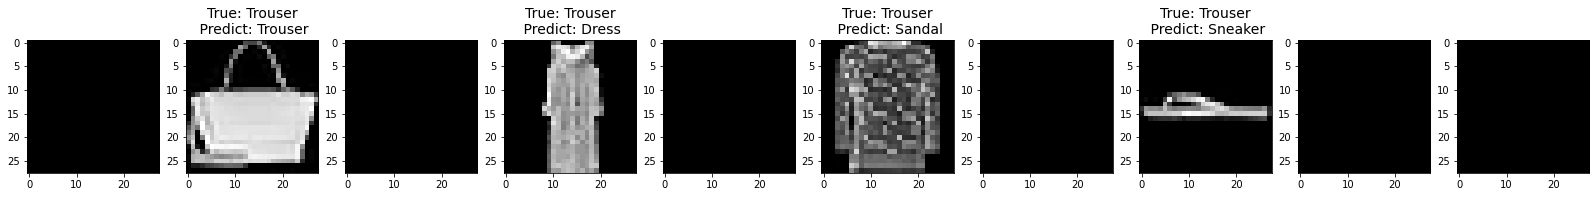

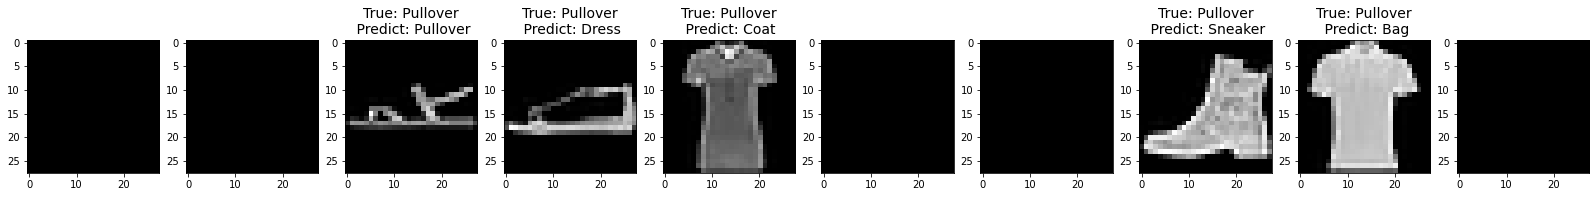

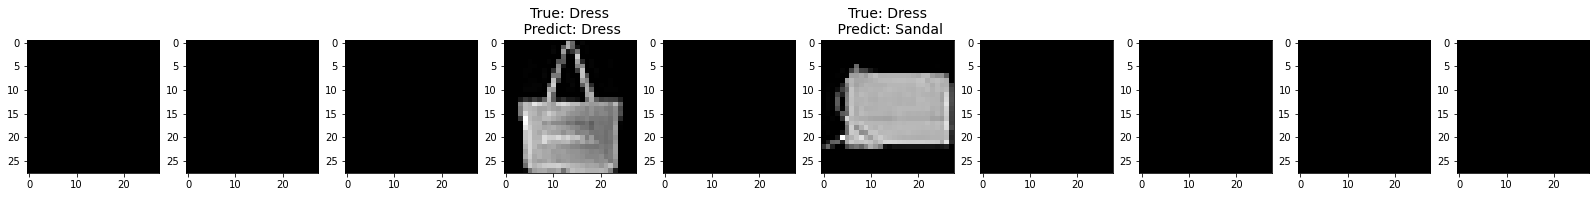

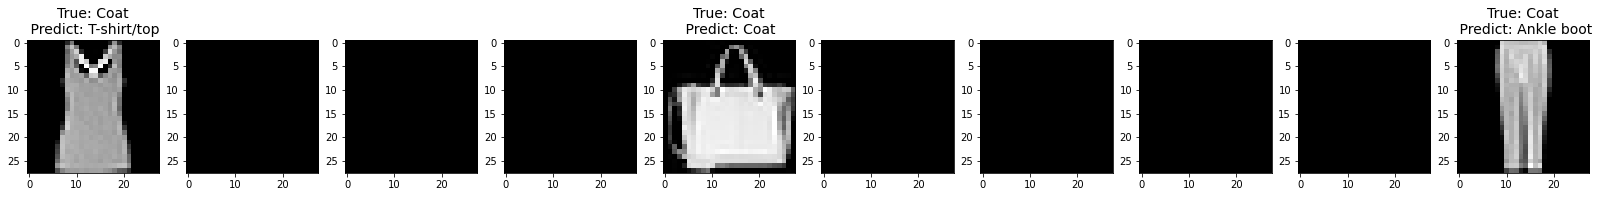

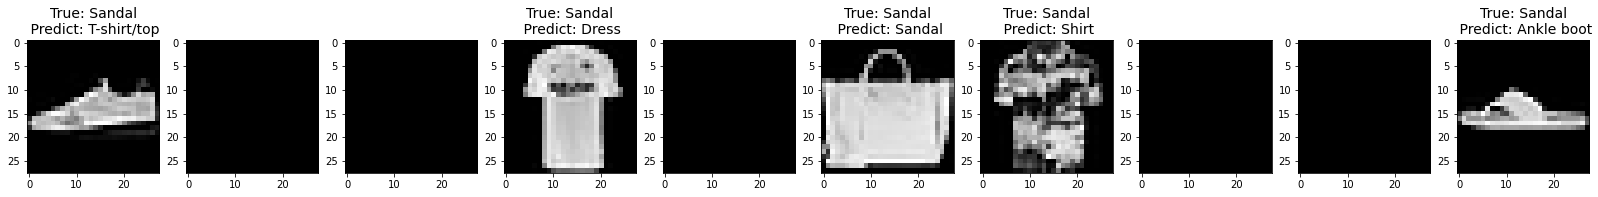

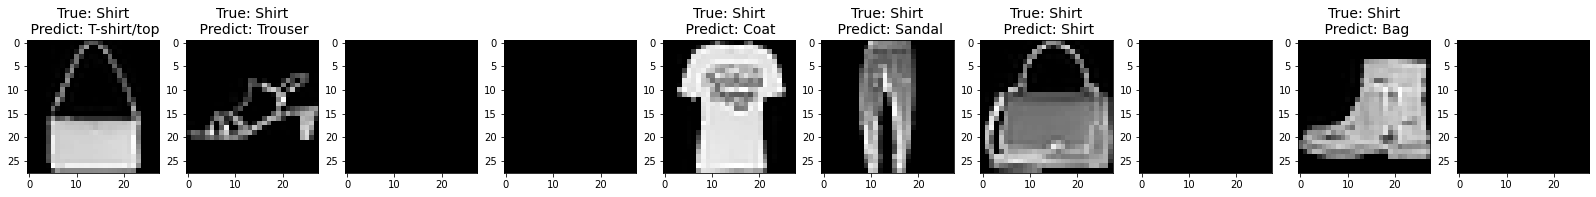

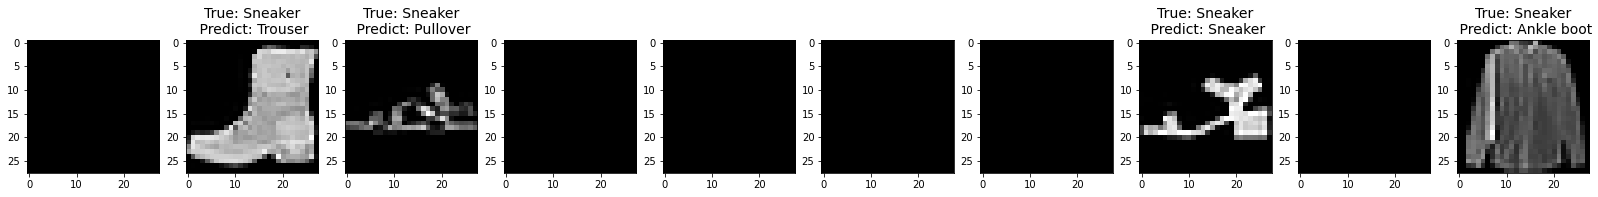

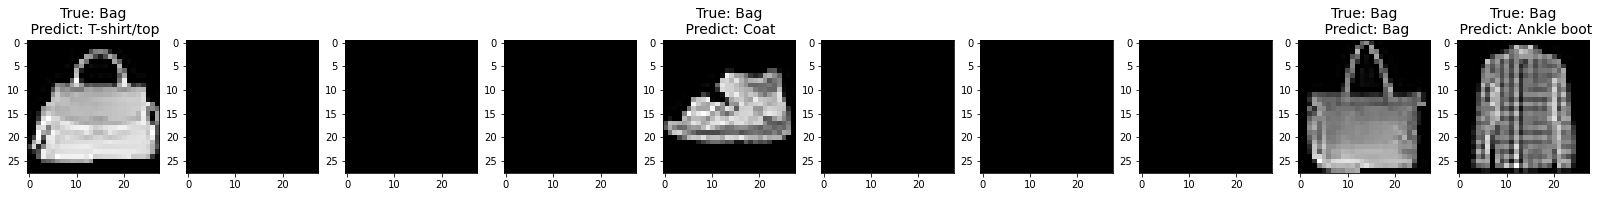

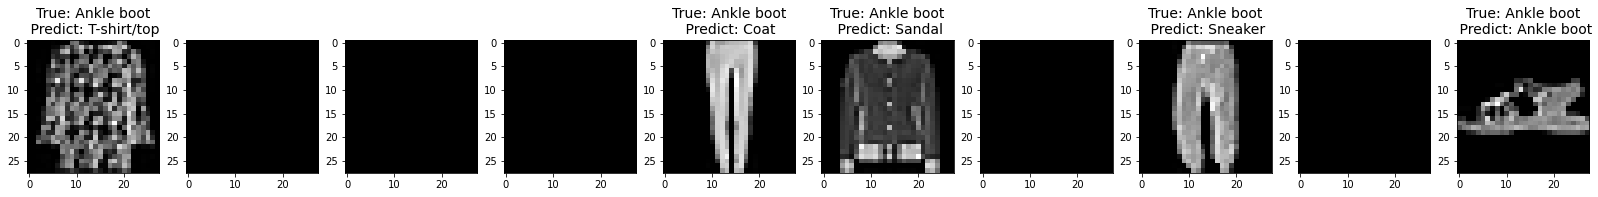

In [254]:
model = MyVGGStyleModel(1, 10)
model.load_state_dict(vgg_model_state_dict)
model.cuda()

evaluate_model(model, test_loader, test_set, ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'])